In [5]:
%config InlineBackend.figure_formats = {"retina", "png"}

import os
import tempfile

os.environ["OPENBLAS_NUM_THREADS"] = "1"

from IPython.display import HTML, display
import h5py
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

plt.rcParams["figure.figsize"] = (5, 4)

import tdgl
from tdgl.geometry import box, circle
from tdgl.visualization.animate import create_animation


#plt.rcParams['animation.ffmpeg_path'] = "C:\\FFmpeg\\bin\\ffmpeg"

np.set_printoptions(linewidth=100)

In [3]:
MAKE_ANIMATIONS = True
tempdir = tempfile.TemporaryDirectory()
tempdir

<TemporaryDirectory '/var/folders/t7/4qq067ln4xzfz0kchzzzlhkw0000gn/T/tmpbo5wdbv2'>

In [4]:
def make_video_from_solution(
    solution,
    quantities=("order_parameter", "phase"),
    fps=20,
    figsize=(5, 4),
):
    """Generates an HTML5 video from a tdgl.Solution."""
    with tdgl.non_gui_backend():
        with h5py.File(solution.path, "r") as h5file:
            anim = create_animation(
                h5file,
                quantities=quantities,
                fps=fps,
                figure_kwargs=dict(figsize=figsize),
            )
            video = anim.to_html5_video()
        return HTML(video)

# KTO Weak Link on the left

## Define Device

In [60]:
length_units = "um"
# Material parameters
xi = 0.02
london_lambda = 3
d = 0.008
# Device geometry
total_width = 0.4
total_length = 1.2
# link_width = total_width / 2
# Outer geometry of the film
right_notch = (
    tdgl.Polygon(points=box(total_width,10.3*xi))
    .rotate(0)
    .translate(dx=2.5 * xi)
)
left_notch = (
    tdgl.Polygon(points=box(total_width,10.3*xi))
    .rotate(0)
    .translate(dx=-total_width)
)
# right_notch = left_notch.scale(xfact=-1)
film = (
    tdgl.Polygon("film", points=box(total_width, total_length))
    .difference(right_notch)
    .difference(left_notch)
    .resample(401)#resample vertices so that they are approximately uniformly distributed along the polygon boundary
    .buffer(0)
)
source = (
    tdgl.Polygon("source", points=box(.7 * total_width, total_length / 100))
    .translate(dy=total_length / 2)
)
drain = source.scale(yfact=-1).set_name("drain")
#  Voltage measurement points
probe_points = [(0, total_length/2-3*xi), (0, -total_length/2+3*xi)
                # ,(total_width/2-xi, total_length/2-3*xi), (total_width/2-xi, -total_length/2+3*xi)
                ]

In [61]:
layer1 = tdgl.Layer(coherence_length=xi, london_lambda=london_lambda, thickness=d, gamma=0.0, u=5.79)
device1 = tdgl.Device(
    "rectangle1",
    layer=layer1,
    film=film,
    #holes=[round_hole, square_hole],
    terminals=[source, drain],
    probe_points=probe_points,
    length_units=length_units,
)

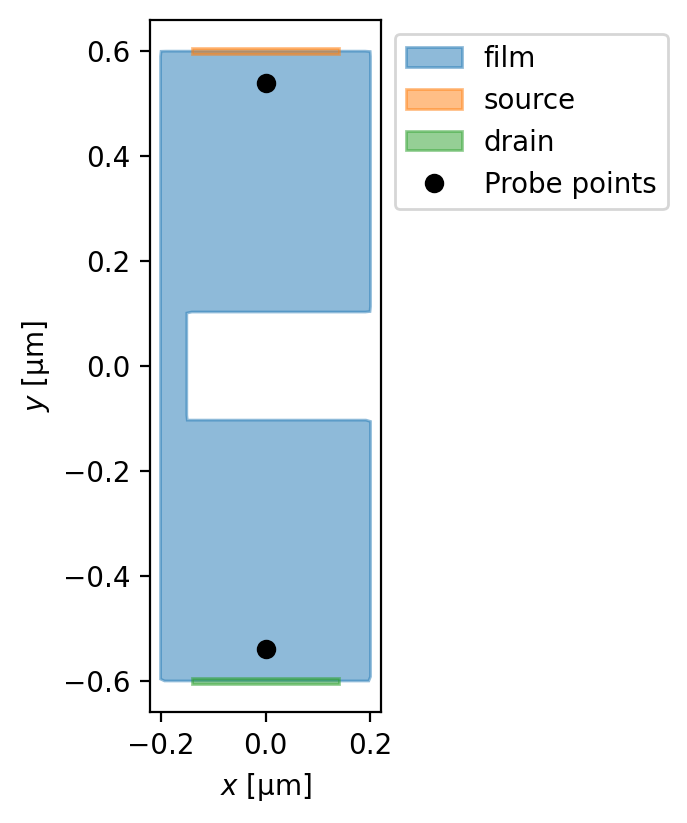

In [62]:
fig, ax = device1.draw()

In [63]:
device1.make_mesh(max_edge_length=0.76*xi , smooth=100)

Constructing Voronoi polygons: 100%|██████████| 5679/5679 [00:00<00:00, 23259.34it/s]


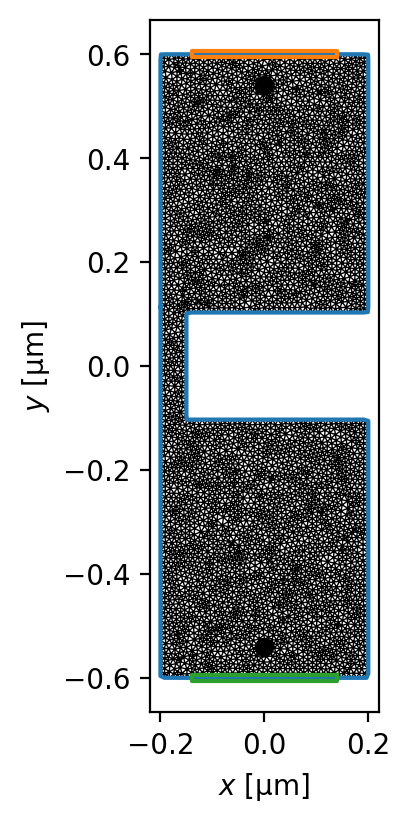

In [64]:
fig, ax = device1.plot(mesh=True, legend=False)
#_ = ax.set_ylim(-7, 7)

In [65]:
device1.mesh_stats()

## Solve for one current value

### Define Disorder

In [85]:
def dis(loc):
    # x,y=loc
    # if y < 5 * xi and y > -5 * xi:
    #     return .9
    return 1

In [86]:
options = tdgl.SolverOptions(
    skip_time = 400,
    solve_time = 1000,
    output_file = os.path.join(tempdir.name, "weak-link-zero-field.h5"),
    field_units = "mT",
    current_units = "uA",
    save_every = 150
)

solution1 = tdgl.solve(
    device1,
    options,
    terminal_currents=dict(source = .15, drain = -.15),
    applied_vector_potential = 200,
    disorder_epsilon = 0.9
)

Output file already exists. Renaming to /var/folders/t7/4qq067ln4xzfz0kchzzzlhkw0000gn/T/tmpbo5wdbv2/weak-link-zero-field-4.h5.
Simulating: 100%|██████████| 1000/1000 [03:22<00:00,  4.93tau/s ]


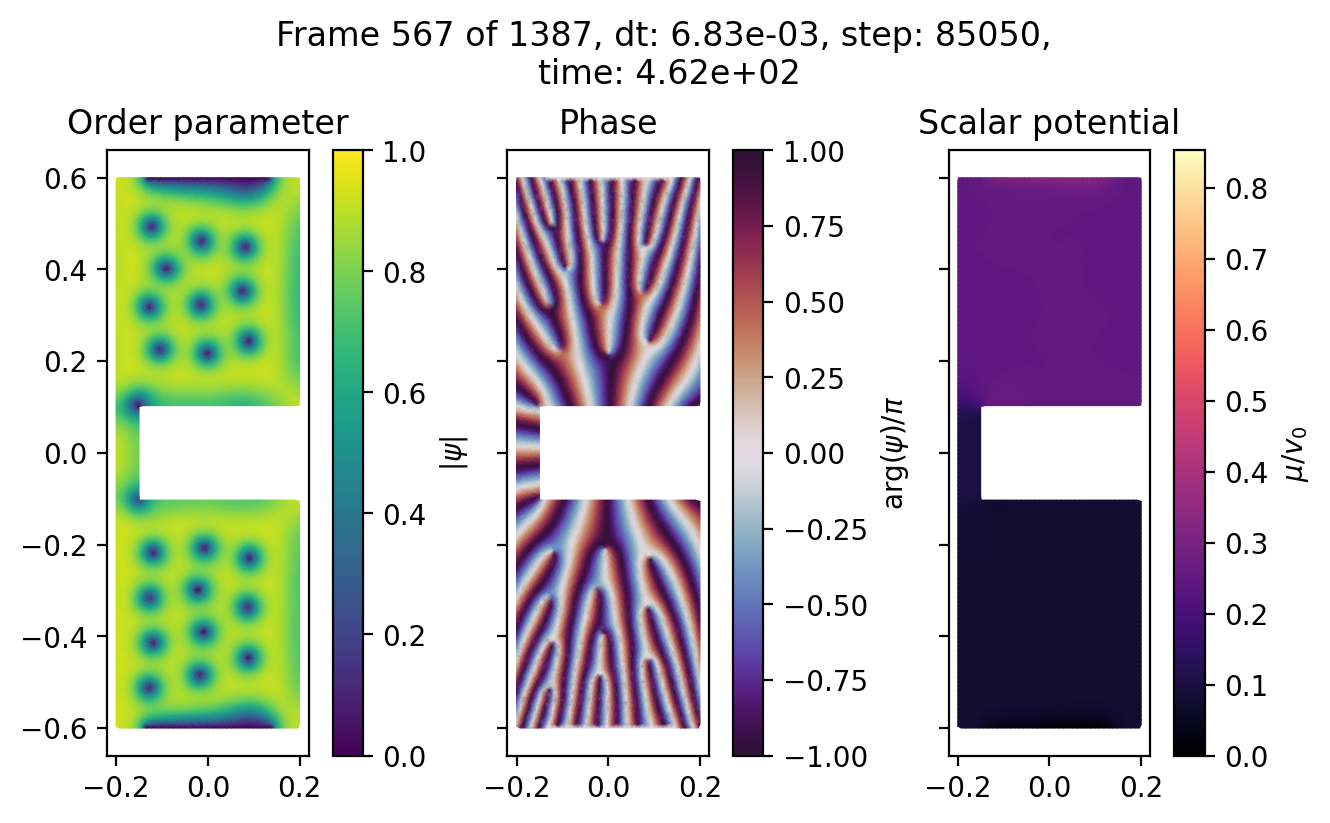

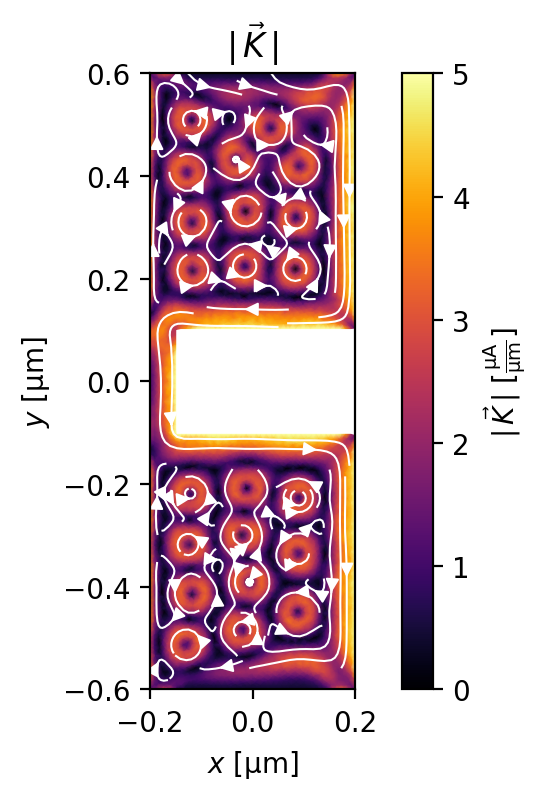

In [87]:
fig1, ax1 = solution1.plot_currents(min_stream_amp = 0.02, vmin = 0, vmax = 5)
fig1.set_size_inches((6, 4))

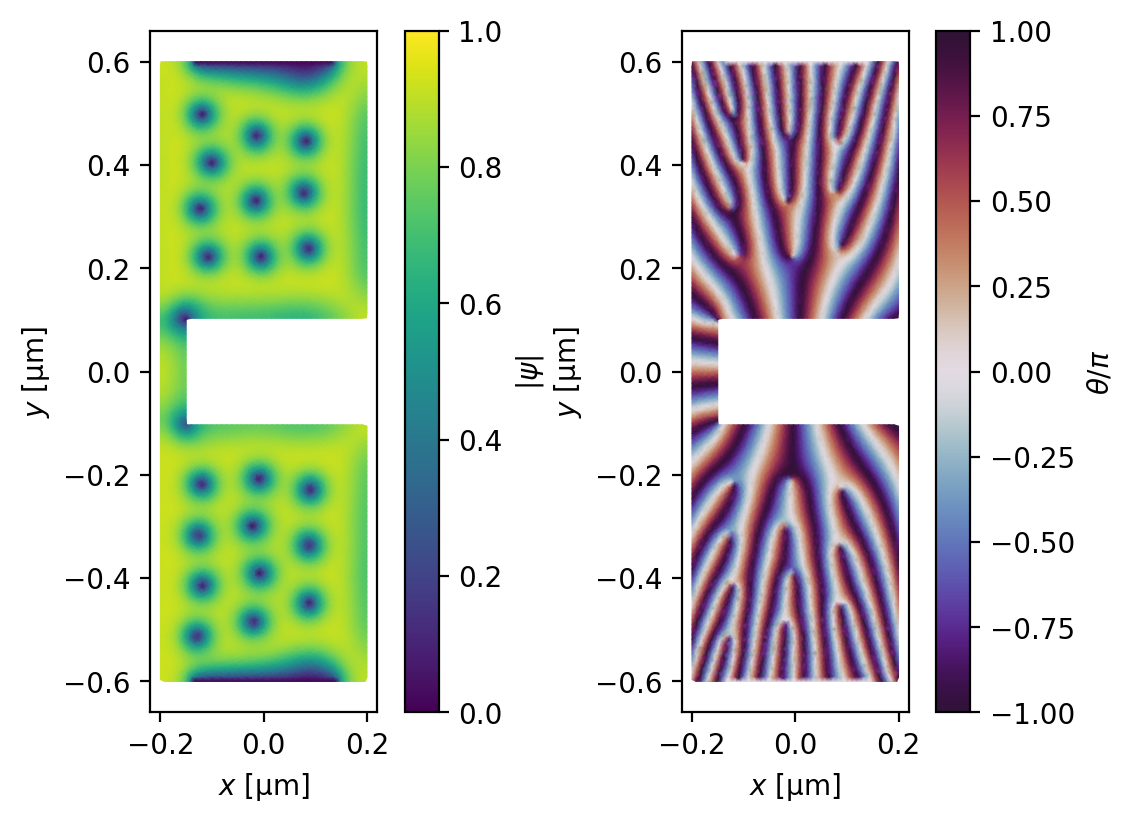

In [88]:
t0 = 400
solution1.solve_step = solution1.closest_solve_step(t0)
fig, axes = solution1.plot_order_parameter(figsize = (5.5, 4))

Text(0, 0.5, '$\\Delta \\phi/ \\pi$')

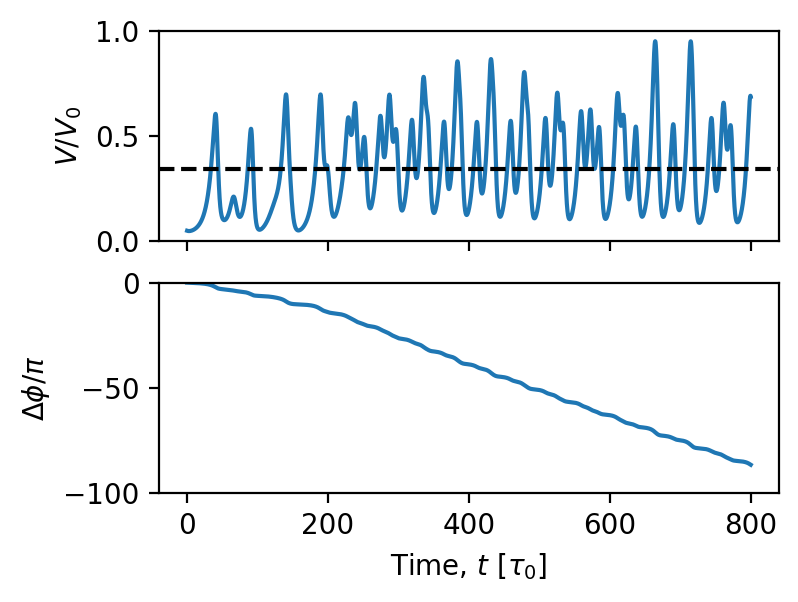

In [124]:
dynamics = solution1.dynamics
fig, axes = dynamics.plot(mean_voltage=True, tmax = 800, grid = False)


fig.set_size_inches((4, 3))
axes[0].set_ylim([-0, 1])
axes[1].set_ylim([-100, 0])
axes[0].set_ylabel('$V/V_0$')
axes[1].set_ylabel('$\Delta \phi/ \pi$')

In [90]:
dynamics.voltage().mean()

0.3868547287543655

In [91]:
if MAKE_ANIMATIONS:
    video1 = make_video_from_solution(
        solution1,
        quantities=['order_parameter', 'phase', 'scalar_potential'],
        figsize=(6.5, 4)
    )
    display(video1)

## Reverse Current

In [92]:
options = tdgl.SolverOptions(
    skip_time = 400,
    solve_time = 1000,
    output_file = os.path.join(tempdir.name, "weak-link-500oe-field.h5"),
    field_units = "mT",
    current_units = "uA",
    save_every = 150
)

solution2 = tdgl.solve(
    device1,
    options,
    terminal_currents=dict(source = -.15, drain = .15),
    applied_vector_potential = 200,
    disorder_epsilon = 0.9,
)

Output file already exists. Renaming to /var/folders/t7/4qq067ln4xzfz0kchzzzlhkw0000gn/T/tmpbo5wdbv2/weak-link-500oe-field-3.h5.
Simulating: 100%|█████████▉| 1000/1000 [00:27<00:00, 36.59tau/s ] 


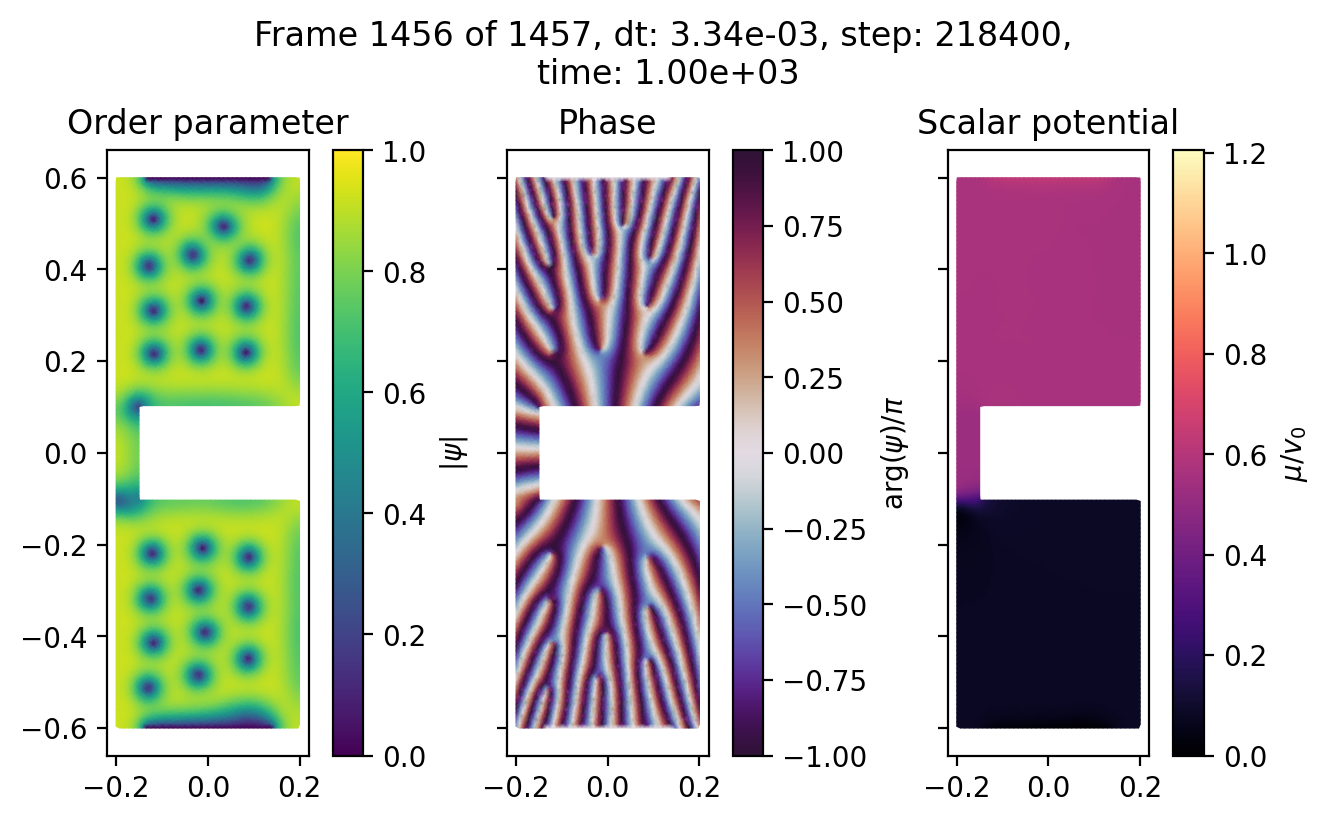

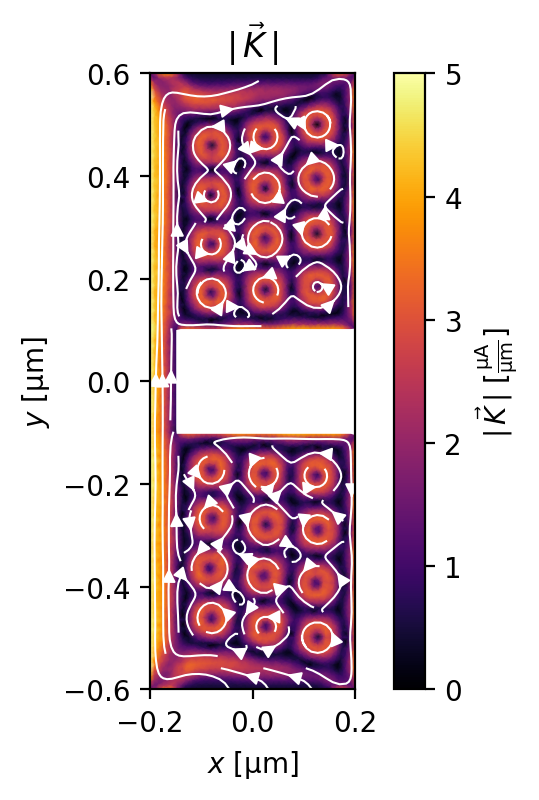

In [93]:
fig2, ax2 = solution2.plot_currents(min_stream_amp = 0.02, vmin = 0, vmax = 5)

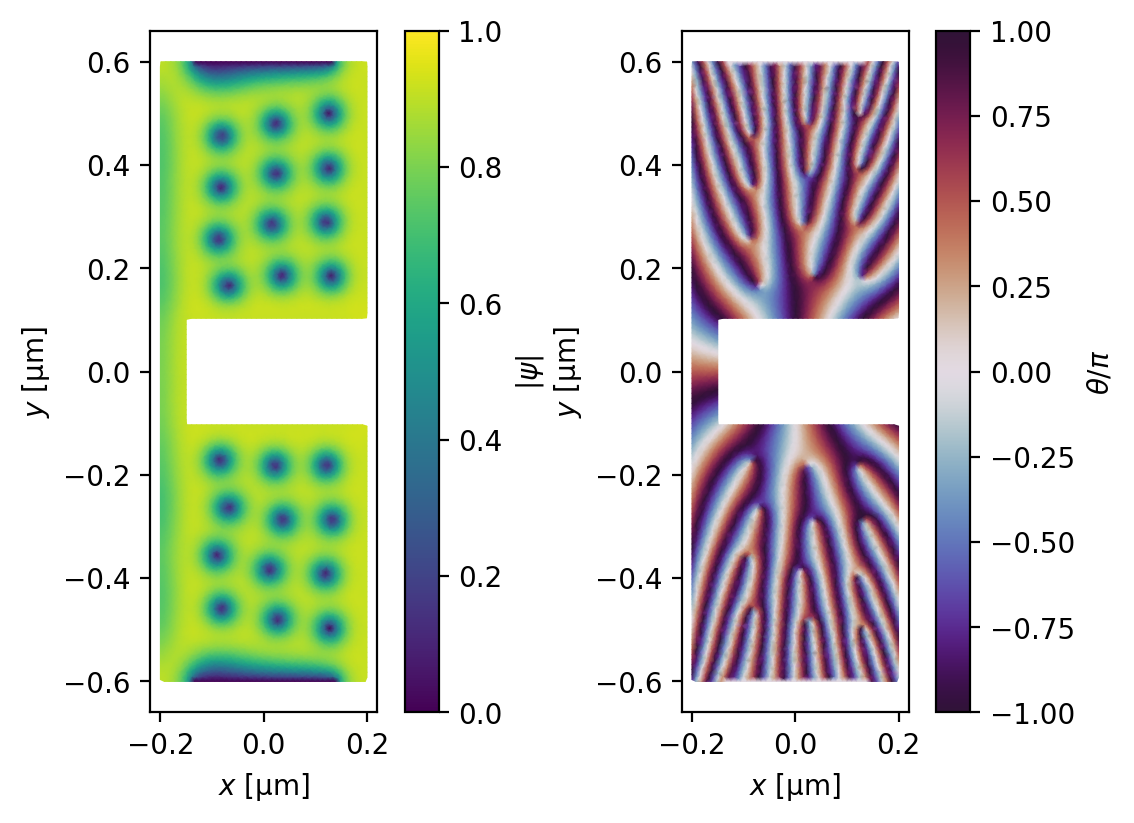

In [94]:
t0 = 400
solution2.solve_step = solution2.closest_solve_step(t0)
fig2, axes2 = solution2.plot_order_parameter(figsize = (5.5, 4))

Text(0, 0.5, '$\\Delta \\phi/ \\pi$')

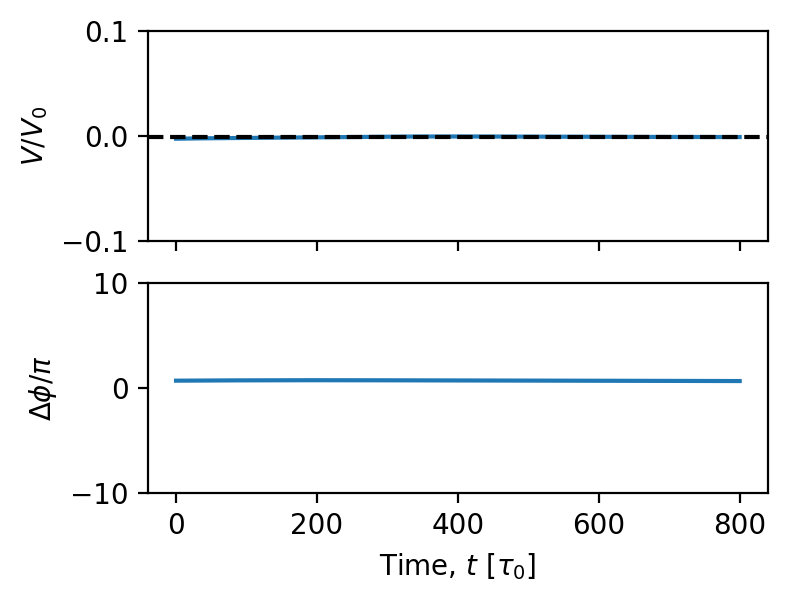

In [125]:
dynamics = solution2.dynamics
fig, axes = dynamics.plot(grid = False, tmax = 800)

fig.set_size_inches((4, 3))
axes[0].set_ylim([-.1, .1])
axes[1].set_ylim([-10, 10])
axes[0].set_ylabel('$V/V_0$')
axes[1].set_ylabel('$\Delta \phi/ \pi$')

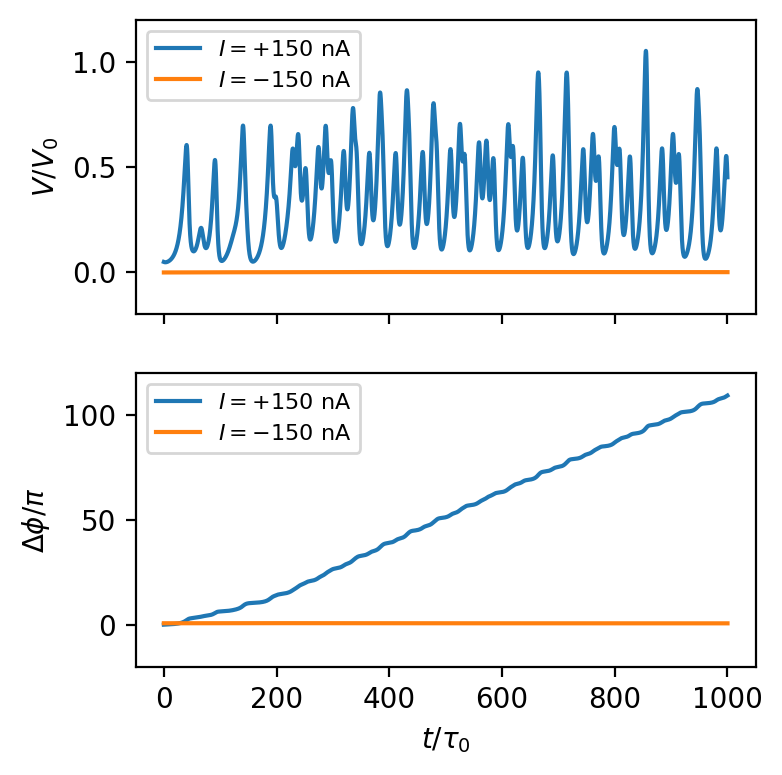

In [215]:
fig, axes = plt.subplots(2, 1, figsize = (4, 4.2))
phases1 = np.unwrap(solution1.dynamics.phase_difference(0, 1)) / np.pi
phases2 = np.unwrap(solution2.dynamics.phase_difference(0, 1)) / np.pi

axes[0].plot(solution1.dynamics.time, solution1.dynamics.voltage())
axes[0].plot(solution2.dynamics.time, solution2.dynamics.voltage())
axes[1].plot(solution1.dynamics.time, -phases1)
axes[1].plot(solution2.dynamics.time, phases2)

axes[0].set_xticklabels([])
axes[0].set_ylim([-0.2, 1.2])
axes[1].set_ylim([-20, 120])
axes[0].set_ylabel('$V/V_0$')
axes[1].set_ylabel('$\Delta \phi/ \pi$')
axes[1].set_xlabel('$t/\\tau_0$')
axes[0].legend(['$I=+150$ nA', '$I=-150$ nA'], fontsize = 8)
axes[1].legend(['$I=+150$ nA', '$I=-150$ nA'], fontsize = 8)

In [108]:
if MAKE_ANIMATIONS:
    video2 = make_video_from_solution(
        solution2,
        quantities=['order_parameter', 'phase', 'scalar_potential'],
        figsize=(6.5, 4)
    )
    display(video2)

## Sweep B and current, save the calculated mean voltage in a dataframe

In [ ]:
current_list = np.append(np.linspace(-0.03, -0.21, 121), 0)
current_list = np.append(current_list, np.linspace(0.03, 0.21, 121))
VvsIvsB = pd.DataFrame({'current':current_list})

for B in range(-600, 605, 25):
    voltage_list = np.array([])

    options0 = tdgl.SolverOptions(
        skip_time = 160,
        solve_time = 90,
        output_file = os.path.join(tempdir.name, f"left-weak-link-{B}oe-field.h5"),
        field_units = "mT",
        current_units = "uA",
        save_every = 100000
    )

    seed_solution = tdgl.solve(
        device1,
        options0,
        terminal_currents=dict(source = current_list[0], drain = -current_list[0]),
        applied_vector_potential = B,
        disorder_epsilon = 0.95,
    )

    options1 = tdgl.SolverOptions(
        skip_time = 80,
        solve_time = 90,
        output_file = os.path.join(tempdir.name, f"left-weak-link-{B}oe-field.h5"),
        field_units = "mT",
        current_units = "uA",
        save_every = 100000
    )

    for current in current_list:
        if current == 0:
            solution = tdgl.solve(
                device1,
                options0,
                terminal_currents=dict(source = 0, drain = 0),
                applied_vector_potential = B,
                disorder_epsilon = 0.95,
            )
        else:
            solution = tdgl.solve(
                device1,
                options1,
                terminal_currents=dict(source = current, drain = -current),
                applied_vector_potential = B,
                disorder_epsilon = 0.95,
                seed_solution = seed_solution
            )
        mean_voltage = solution.dynamics.voltage().mean()
        voltage_list = np.append(voltage_list, mean_voltage)
        seed_solution = solution
    
    VvsIvsB[str(B)] = voltage_list

VvsIvsB.set_index('current', inplace = True)
VvsIvsB.sort_index(inplace=True, ascending=True)
VvsIvsB.to_csv('left-weak-link-VvsIvsB-new4.csv')

Simulating: 100%|█████████▉| 90/90 [00:04<00:00, 18.25tau/s ]
Output file already exists. Renaming to /var/folders/t7/4qq067ln4xzfz0kchzzzlhkw0000gn/T/tmpbo5wdbv2/left-weak-link--600oe-field-1.h5.
Simulating: 100%|█████████▉| 90/90 [00:03<00:00, 23.64tau/s ]
Output file already exists. Renaming to /var/folders/t7/4qq067ln4xzfz0kchzzzlhkw0000gn/T/tmpbo5wdbv2/left-weak-link--600oe-field-2.h5.
Simulating: 100%|█████████▉| 90/90 [00:02<00:00, 31.71tau/s ]
Output file already exists. Renaming to /var/folders/t7/4qq067ln4xzfz0kchzzzlhkw0000gn/T/tmpbo5wdbv2/left-weak-link--600oe-field-3.h5.
Simulating: 100%|█████████▉| 90/90 [00:02<00:00, 31.40tau/s ]
Output file already exists. Renaming to /var/folders/t7/4qq067ln4xzfz0kchzzzlhkw0000gn/T/tmpbo5wdbv2/left-weak-link--600oe-field-4.h5.
Simulating: 100%|█████████▉| 90/90 [00:04<00:00, 19.75tau/s ]
Output file already exists. Renaming to /var/folders/t7/4qq067ln4xzfz0kchzzzlhkw0000gn/T/tmpbo5wdbv2/left-weak-link--600oe-field-5.h5.
Simulating: 100

FileNotFoundError: [Errno 2] No such file or directory: '/var/folders/t7/4qq067ln4xzfz0kchzzzlhkw0000gn/T/tmpbo5wdbv2/left-weak-link--575oe-field-158.h5.tmp'

In [6]:
VvsIvsB=pd.read_csv('left-thin-weak-link-VvsIvsB-new3.csv')

In [7]:
VvsIvsB.set_index('current', inplace = True)

In [8]:
VvsIvsB.columns = [str(-10*int(B)) for B in VvsIvsB.columns]

In [9]:
VvsIvsB

6000      5750      5500      5250      5000      4750      4500  \
current                                                                         
-0.2100 -6.598074 -6.439471 -6.292278 -6.230827 -6.105790 -6.003582 -5.954348   
-0.2085 -6.543988 -6.411521 -6.234502 -6.169934 -6.060489 -5.970577 -5.868522   
-0.2070 -6.493221 -6.331982 -6.182373 -6.089888 -6.004330 -5.936180 -5.844697   
-0.2055 -6.439170 -6.289142 -6.155802 -6.037669 -5.940763 -5.887158 -5.773170   
-0.2040 -6.389072 -6.236576 -6.096445 -5.995502 -5.890920 -5.842852 -5.737710   
...           ...       ...       ...       ...       ...       ...       ...   
 0.2040  6.526968  6.495657  6.438205  6.348634  6.239258  6.130200  6.038702   
 0.2055  6.575976  6.537969  6.485534  6.406580  6.308192  6.154432  6.077300   
 0.2070  6.625639  6.594568  6.543134  6.458287  6.367870  6.230536  6.134791   
 0.2085  6.673569  6.634472  6.588254  6.508890  6.411619  6.292698  6.199657   
 0.2100  6.727623  6.694528  6.641694  6.569675  6.484748  6.322940  6.253578   

             4250      4000      3750  ...     -3750     -4000     -4250  \
current                                ...                                 
-0.2100 -5.836296 -5.747896 -5.537591  ... -5.742501 -5.924903 -6.053508   
-0.2085 -5.797296 -5.655606 -5.601805  ... -5.690359 -5.897646 -6.035710   
-0.2070 -5.747174 -5.689086 -5.489889  ... -5.659074 -5.832263 -6.000214   
-0.2055 -5.662417 -5.580781 -5.387861  ... -5.589125 -5.788364 -5.926506   
-0.2040 -5.652970 -5.599209 -5.391541  ... -5.498465 -5.722384 -5.862437   
...           ...       ...       ...  ...       ...       ...       ...   
 0.2040  5.897450  5.700013  5.514731  ...  5.296181  5.468755  5.667596   
 0.2055  5.921051  5.757428  5.588836  ...  5.369782  5.551398  5.665586   
 0.2070  5.998371  5.821764  5.606454  ...  5.482280  5.575782  5.777626   
 0.2085  6.036425  5.852722  5.692312  ...  5.534273  5.624705  5.824047   
 0.2100  6.077407  5.922621  5.730478  ...  5.577680  5.688092  5.822049   

            -4500     -4750     -5000     -5250     -5500     -5750     -6000  
current                                                                        
-0.2100 -6.246756 -6.353915 -6.473525 -6.571064 -6.646923 -6.693112 -6.725266  
-0.2085 -6.203049 -6.271695 -6.430743 -6.507932 -6.600000 -6.644834 -6.676831  
-0.2070 -6.128110 -6.225177 -6.358040 -6.448761 -6.545841 -6.589968 -6.623946  
-0.2055 -6.081428 -6.171361 -6.294402 -6.408600 -6.490274 -6.538860 -6.578574  
-0.2040 -6.042730 -6.107244 -6.250110 -6.347425 -6.436194 -6.496236 -6.529344  
...           ...       ...       ...       ...       ...       ...       ...  
 0.2040  5.726209  5.854609  5.904727  5.997241  6.106254  6.236808  6.409357  
 0.2055  5.769325  5.888826  5.934889  6.045669  6.173162  6.251016  6.453109  
 0.2070  5.845141  5.934909  5.989684  6.132825  6.201610  6.324883  6.504236  
 0.2085  5.871681  5.981654  6.068706  6.198815  6.250593  6.388394  6.551760  
 0.2100  5.953738  6.027127  6.097681  6.228118  6.299159  6.440838  6.604775  

[243 rows x 49 columns]

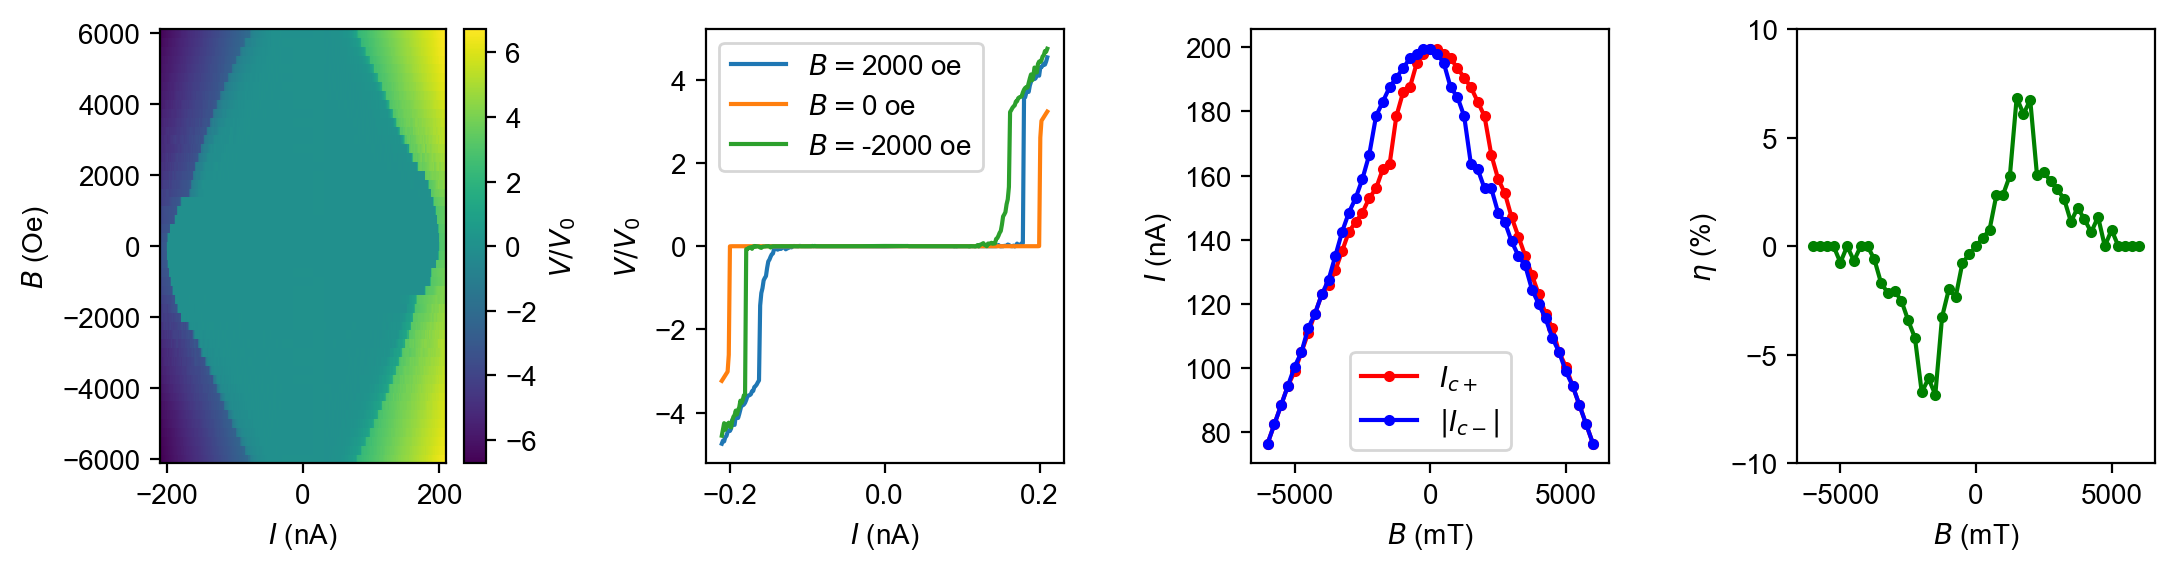

In [44]:
fig, axes = plt.subplots(1, 4, figsize = (11, 3))
Icm_list = np.array([])
Icp_list = np.array([])
B_list = np.array([])

for i, B in enumerate(VvsIvsB.columns[::]):
    VvsI = VvsIvsB[B]
    for I in VvsI.index:
        if VvsI.loc[I] > -1:
            Icm = I
            break
    for I in VvsI.index[::-1]:
        if VvsI.loc[I] < 1:
            Icp = I
            break
    B_list = np.append(B_list, int(B))
    Icm_list = np.append(Icm_list, Icm)
    Icp_list = np.append(Icp_list, Icp)
#     axes[0].plot(VvsI.index, VvsI.values + 2 * i, label = B + ' mT', color = [i / 48, 0, 1- i /48])
# axes[0].set_xlabel('I (uA)')
# axes[0].set_ylabel('V (V0)')

# Create the intensity plot (pcolormesh is great for this)
# Note: Shading='auto' helps if dimensions don't perfectly match
im = axes[0].pcolormesh(x_axis_nA, y_axis_Oe, z_values, shading='auto', cmap='viridis')

# Add a color bar
cbar = fig.colorbar(im, ax=axes[0])
cbar.set_label('$V/V_0$') # Replace with your Z-axis unit/name

# Set labels and title
axes[0].set_xlabel('$I$ (nA)')
axes[0].set_ylabel('$B$ (Oe)')
# axes[0].set_title('Intensity Plot')

axes[1].plot(VvsIvsB.iloc[::, 16], label = '$B=$'+VvsIvsB.columns[16]+' oe')
axes[1].plot(VvsIvsB.iloc[::, 24], label = '$B=$'+VvsIvsB.columns[24]+' oe')
axes[1].plot(VvsIvsB.iloc[::, -17], label = '$B=$'+VvsIvsB.columns[-17]+' oe')
axes[1].set_xlabel('$I$ (nA)')
axes[1].set_ylabel('$V/V_0$')
axes[1].legend()

axes[2].plot(B_list, Icp_list * 1000, 'ro-', markersize = 3, label = '$I_{c+}$')
axes[2].plot(B_list, -Icm_list * 1000, 'bo-', markersize = 3, label = '$|I_{c-}|$')
axes[2].set_xlabel('$B$ (mT)')
axes[2].set_ylabel('$I$ (nA)')
# axes[2].hlines([0.175], xmin = -175, xmax = 175, color='k')
axes[2].legend()

axes[3].plot(B_list, (Icp_list+Icm_list) / (Icp_list-Icm_list) * 100, 'go-', markersize = 3)
axes[3].set_ylim([-10, 10])
axes[3].set_xlabel('$B$ (mT)')
axes[3].set_ylabel('$\eta$ (%)')

plt.tight_layout()

# VvsIvsB.to_csv('left-thin-weak-link-VvsIvsB-new3.csv')

In [25]:
import plotly.graph_objects as go
# 2. Transpose the DataFrame
df_transposed = VvsIvsB.T.iloc[::-1]
x_axis_nA = df_transposed.columns * 1000
y_axis_Oe = B_list[::-1]
z_values = df_transposed.values

# 3. Create the heatmap trace with the new color bar title
fig = go.Figure(data=go.Heatmap(
                   z=z_values,
                   x=x_axis_nA,
                   y=y_axis_Oe,
                   colorscale='Viridis',
                   # MODIFICATION: Changed the color bar title
                   colorbar=dict(title='<i>V</i>/<i>V</i><sub>0</sub>') 
               ))

# 4. Update layout with new y-axis limits and ticks
fig.update_layout(
    xaxis_title='<i>I</i> (nA)',
    yaxis_title='<i>B</i> (Oe)',
    font=dict(
        family="Arial",
        size=12
    ),
    width=320,
    height=280,
    margin=dict(l=10, r=10, b=10, t=10, pad=1),
    # MODIFICATION: Added yaxis dictionary to control range and ticks
    yaxis=dict(
        range=[-5000, 5000],
        tickvals=[-4000, -2000, 0, 2000, 4000]
    )
)

fig.update_xaxes(
    ticks="outside",       # Show ticks on the outside of the axis line
    tickwidth=1,           # Thickness of the ticks in pixels
    tickcolor='black',   # Color of the ticks
    ticklen=5,            # Length of the ticks in pixels
    mirror=True            # Show ticks on the top axis as well
)

fig.update_yaxes(
    ticks="outside",
    tickwidth=1,
    tickcolor='black',
    ticklen=5,
    mirror=True            # Show ticks on the right axis as well
)

fig.write_image("plotly_intensity_plot.pdf", scale = 0.5)
fig.show()


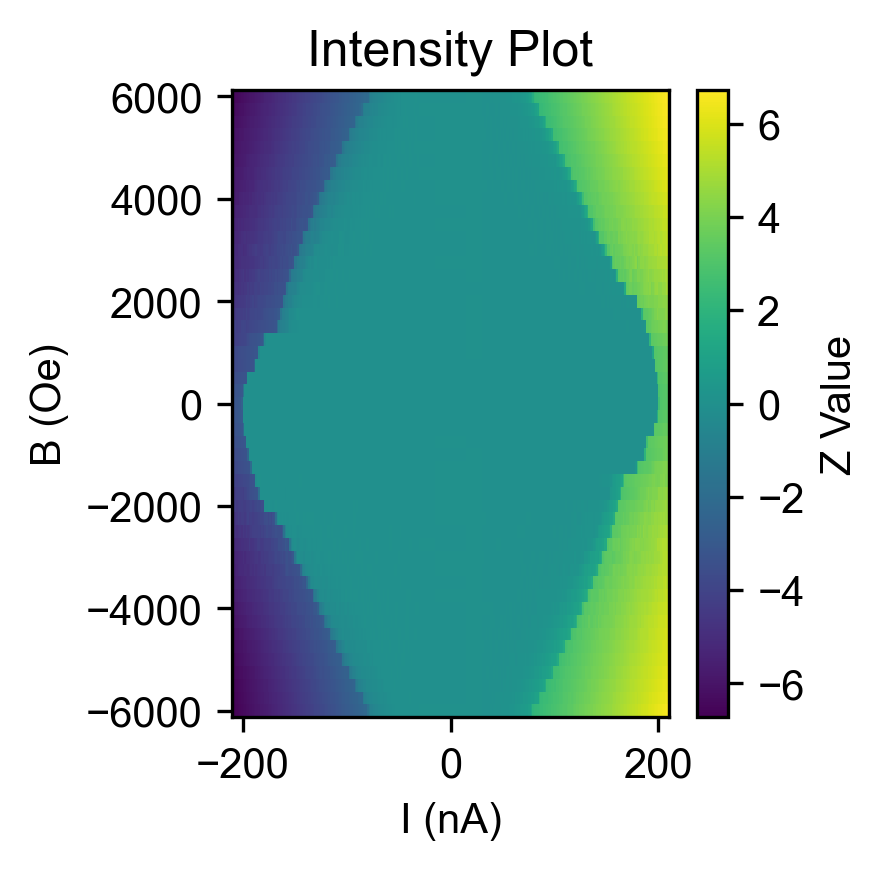

In [26]:
import matplotlib.pyplot as plt
import matplotlib as mpl

# Set the font to Arial
mpl.rcParams['font.family'] = 'Arial'

# Create a figure with a specific size in inches
fig, ax = plt.subplots(figsize=(3, 3), dpi=150)

# Create the intensity plot (pcolormesh is great for this)
# Note: Shading='auto' helps if dimensions don't perfectly match
im = ax.pcolormesh(x_axis_nA, y_axis_Oe, z_values, shading='auto', cmap='viridis')

# Add a color bar
cbar = fig.colorbar(im, ax=ax)
cbar.set_label('Z Value') # Replace with your Z-axis unit/name

# Set labels and title
ax.set_xlabel('I (nA)')
ax.set_ylabel('B (Oe)')
ax.set_title('Intensity Plot')

# Ensure the layout is tight
plt.tight_layout()
plt.show()

# To save the figure, you can use:
# fig.savefig("matplotlib_intensity_plot.pdf", dpi=300)

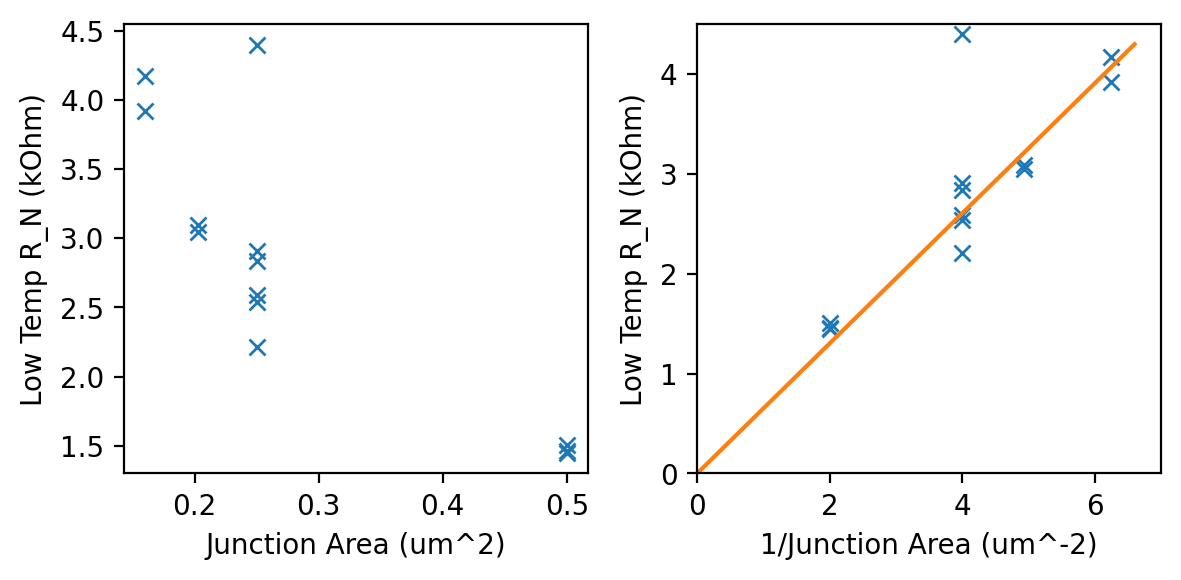

In [379]:
size_array = np.array([0.5, 0.5, 0.5, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.16, 0.16, 0.2025, 0.2025])
R_room_array = np.array([1.23, 1.28, 1.24, 1.88, 2.2, 2.16, 3.74, 2.41, 2.47, 3.33, 3.55, 2.63, 2.59])
R_n_array = R_room_array/0.85

fig, axes = plt.subplots(1, 2, figsize = (6, 3))
axes[0].plot(size_array, R_n_array, 'x')
axes[0].set_xlabel('Junction Area (um^2)')
axes[0].set_ylabel('Low Temp R_N (kOhm)')
axes[1].plot(1/size_array, R_n_array, 'x')
axes[1].plot([0, 6.6], [0, 4.3])
axes[1].set_xlabel('1/Junction Area (um^-2)')
axes[1].set_ylabel('Low Temp R_N (kOhm)')
axes[1].set_xlim([0, 7])
axes[1].set_ylim([0, 4.5])
fig.tight_layout()